In [1]:
# Imports
import os
from pathlib import Path
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Forecast Bike Demand to Optimize Fleet Availability
## Forecast short-term bike demand to improve bike availability and fleet allocation across stations and time

Given historical BikeTown usage data, forecast station-level bike demand 3 days ahead in order to optimize bicycle allocation and reduce station shortages or overflows.

## 1. Read Dataset

In [2]:
DATA_PATH = Path("projects/biketown-forecast/data/raw/week10_biketown.zip")

data = pd.read_csv(
    DATA_PATH,
    compression="zip",
    low_memory=False
)

## 2. Data Clean up

In [3]:
data.head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,TripType,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
0,1,1282087.0,Casual,NE Sandy at 16th,45.524407,-122.649769,7/19/2016,10:22:00,NaN,45.535057,-122.654557,7/19/2016,10:48:00,NaN,6083.0,0468 BIKETOWN,1.19,00:25:46,keypad,False
1,2,1282113.0,Subscriber,NaN,45.531504,-122.659653,7/19/2016,10:28:00,NaN,45.502478,-122.672348,7/19/2016,10:47:00,NaN,6238.0,0774 BIKETOWN,2.95,00:18:44,mobile,False
2,3,1282118.0,Subscriber,NW Kearney at 23rd,45.529142,-122.698703,7/19/2016,10:30:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,12:37:00,NaN,7271.0,0359 BIKETOWN,13.46,02:06:19,mobile,False
3,4,1282120.0,Subscriber,NaN,45.502478,-122.672348,7/19/2016,10:31:00,SE 2nd Pl at Tilikum Way,45.506242,-122.663338,7/19/2016,10:37:00,NaN,6875.0,0078 BIKETOWN,0.53,00:05:21,keypad,False
4,5,1282123.0,Subscriber,NaN,NaN,NaN,7/19/2016,10:32:00,NaN,NaN,NaN,7/19/2016,10:37:00,NaN,7160.0,0131 BIKETOWN,0.00,00:05:18,keypad,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523588 entries, 0 to 523587
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        523588 non-null  int64  
 1   RouteID           519500 non-null  float64
 2   PaymentPlan       519500 non-null  object 
 3   StartHub          408880 non-null  object 
 4   StartLatitude     519088 non-null  float64
 5   StartLongitude    519088 non-null  float64
 6   StartDate         519500 non-null  object 
 7   StartTime         519500 non-null  object 
 8   EndHub            450115 non-null  object 
 9   EndLatitude       519111 non-null  float64
 10  EndLongitude      519111 non-null  float64
 11  EndDate           519194 non-null  object 
 12  EndTime           519194 non-null  object 
 13  TripType          957 non-null     object 
 14  BikeID            519500 non-null  float64
 15  BikeName          519371 non-null  object 
 16  Distance_Miles    51

1. RouteID - check if RouteID.Null = PaymentPlan.NUll
2. PaymentPlan - check Null
3. StartHub - Check Null what kind of info has (does it have EndHub)
4. StartLatitude - Check if you can find StartHub based on Latitude / Longitude
5. StartDate / StartTime - Check Nulls. If the same as RouteID / PaymentPlan Nulls. Maybe good to delete
6. EndHub - Check Null as they don't bring info if no StartHub. (Both Missing - doesn't help)
7. EndLatitude - check if you can find EndHub - based on this
8. EndDate / EndTime - Check Nulls
9. TripType - check correlations with PaymentPlan. Not many info as many missing
10. mBikeID / BikeName - does it bring any info to our case?
11. Distance_Miles - This is interesting but don't know if will have any impact for our case
12. Duration - This is interesting but don't know if will have any impact for our case
13. RentalAccessPath - ??
14. MultipleRental - ??


In [5]:
data[data['RouteID'].isna()]

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,TripType,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
166627,166628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166628,166629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166629,166630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166630,166631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166631,166632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450219,450220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450220,450221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450221,450222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450222,450223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Dropping NaN
data = data[data['RouteID'].notna()]

In [14]:
# Check where "StartHub", "EndHub", "StartLatitude" and "EndLatitude" (GPS Coordinates) and Null. This doesn't bring anything to our case. We need these locations.
data[
    (data['StartHub'].isna() & data['EndHub'].isna()) &
    (data['StartLatitude'].isna() & data['EndLatitude'].isna())
    ].head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,TripType,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
4,5,1282123.0,Subscriber,NaN,NaN,NaN,7/19/2016,10:32:00,NaN,NaN,NaN,7/19/2016,10:37:00,NaN,7160.0,0131 BIKETOWN,0.0,00:05:18,keypad,False
2240,2241,1289891.0,Casual,NaN,NaN,NaN,7/20/2016,12:58:00,NaN,NaN,NaN,7/20/2016,15:38:00,NaN,6837.0,0538 BIKETOWN,0.0,02:39:23,keypad,True
2724,2725,1291523.0,Casual,NaN,NaN,NaN,7/20/2016,16:29:00,NaN,NaN,NaN,7/20/2016,16:47:00,NaN,6223.0,0353 BIKETOWN,0.0,00:17:56,keypad,False
5237,5238,1299915.0,Casual,NaN,NaN,NaN,7/21/2016,21:56:00,NaN,NaN,NaN,7/21/2016,22:04:00,NaN,6246.0,0511 BIKETOWN,0.0,00:07:59,keypad,False
8101,8102,1309888.0,Casual,NaN,NaN,NaN,7/23/2016,15:04:00,NaN,NaN,NaN,7/23/2016,15:11:00,NaN,6520.0,0081 BIKETOWN,0.0,00:06:48,keypad,False


In [15]:
data = data.dropna(subset=['StartHub', 'EndHub', 'StartLatitude', 'EndLatitude'], how='all')

In [16]:
# Checking if StartHub, StartLatitude and StartLongitude is null. 
# This is a problem to understand if we count bikes at startHub but it is info as we bring these bikes to specific location 
len(data[
    (data['StartHub'].isna() & data['StartLatitude'].isna() & data['StartLongitude'].isna())
    ])

31

In [17]:
# Look at trip type
# This is interesting as we can use this info in our study, but too much missing values. 
# Column can be dropped
data['TripType'].value_counts(dropna=False)

TripType
NaN           518163
recreation       490
commute          277
errand           122
work              67
Name: count, dtype: int64

In [18]:
data.drop(columns=['TripType'], inplace=True)

In [19]:
# Doesn't really help in our study
data[['RentalAccessPath', 'MultipleRental']]

,RentalAccessPath,MultipleRental
0,keypad,False
1,mobile,False
2,mobile,False
3,keypad,False
5,keypad,False
...,...,...
523583,keypad_rfid_card,False
523584,keypad,False
523585,mobile,False
523586,keypad,False


In [20]:
data[data['MultipleRental'] == True].head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
14,15,1282195.0,Subscriber,SE 9th at Belmont,45.516333,-122.656632,7/19/2016,10:44:00,SE 9th at Belmont,45.516333,-122.656632,NaN,NaN,7320.0,0990 AIR TRAINER,0.35,NaN,mobile,True
23,24,1282254.0,Casual,NW 21st at Johnson,45.528268,-122.694562,7/19/2016,10:53:00,NW 23rd at Overton,45.532116,-122.698630,7/19/2016,13:00:00,6528.0,0646 BIKETOWN,8.14,02:06:20,keypad,True
26,27,1282262.0,Casual,NW 21st at Johnson,45.528268,-122.694562,7/19/2016,10:55:00,NaN,45.502478,-122.672348,7/19/2016,11:56:00,6539.0,0917 BIKETOWN,3.64,01:01:34,keypad,True
39,40,1282342.0,Casual,NW 13th at Marshall,45.530804,-122.684423,7/19/2016,11:09:00,NaN,45.524390,-122.682184,NaN,NaN,7232.0,0030 BIKETOWN,0.64,NaN,keypad,True
40,41,1282345.0,Casual,NW 13th at Marshall,45.530804,-122.684423,7/19/2016,11:10:00,NaN,45.524390,-122.682184,7/19/2016,11:51:00,6667.0,0352 BIKETOWN,0.60,00:41:33,keypad,True


In [21]:
# Dropping 'RentalAccessPath', 'MultipleRental'
data.drop(columns=['RentalAccessPath', 'MultipleRental'], inplace=True)

In [22]:
# Change the datatype of 'RouteID'
data['RouteID'] = data['RouteID'].astype('int64')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519119 entries, 0 to 523587
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      519119 non-null  int64  
 1   RouteID         519119 non-null  int64  
 2   PaymentPlan     519119 non-null  object 
 3   StartHub        408880 non-null  object 
 4   StartLatitude   519088 non-null  float64
 5   StartLongitude  519088 non-null  float64
 6   StartDate       519119 non-null  object 
 7   StartTime       519119 non-null  object 
 8   EndHub          450115 non-null  object 
 9   EndLatitude     519111 non-null  float64
 10  EndLongitude    519111 non-null  float64
 11  EndDate         518814 non-null  object 
 12  EndTime         518814 non-null  object 
 13  BikeID          519119 non-null  float64
 14  BikeName        518990 non-null  object 
 15  Distance_Miles  519119 non-null  float64
 16  Duration        516978 non-null  object 
dtypes: float64(6), 

In [24]:
# Try to find StartHub and EndHub based on Latitude and Longitude

# Build one "lat/lon to hub" mapping from both start and end info
known_start = data.loc[data["StartHub"].notna(), ["StartLatitude","StartLongitude","StartHub"]].rename(
    columns={"StartLatitude":"lat", "StartLongitude":"lon", "StartHub":"hub"}
)

known_end = data.loc[data["EndHub"].notna(), ["EndLatitude","EndLongitude","EndHub"]].rename(
    columns={"EndLatitude":"lat", "EndLongitude":"lon", "EndHub":"hub"}
)

known = pd.concat([known_start, known_end], ignore_index=True)

# choose the most frequent hub to avoid if there is wrong misspeling in the data
hub_map = (known.groupby(["lat","lon"])["hub"]
                .agg(lambda s: s.value_counts().idxmax()))

In [25]:
# Try to fill StartHub using Start coords
mask_s = data["StartHub"].isna()
data.loc[mask_s, "StartHub"] = (
    data.loc[mask_s].set_index(["StartLatitude","StartLongitude"]).index.map(hub_map)
)

# Try to fill EndHub using End coords
mask_e = data["EndHub"].isna()
data.loc[mask_e, "EndHub"] = (
    data.loc[mask_e].set_index(["EndLatitude","EndLongitude"]).index.map(hub_map)
)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519119 entries, 0 to 523587
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      519119 non-null  int64  
 1   RouteID         519119 non-null  int64  
 2   PaymentPlan     519119 non-null  object 
 3   StartHub        408880 non-null  object 
 4   StartLatitude   519088 non-null  float64
 5   StartLongitude  519088 non-null  float64
 6   StartDate       519119 non-null  object 
 7   StartTime       519119 non-null  object 
 8   EndHub          450115 non-null  object 
 9   EndLatitude     519111 non-null  float64
 10  EndLongitude    519111 non-null  float64
 11  EndDate         518814 non-null  object 
 12  EndTime         518814 non-null  object 
 13  BikeID          519119 non-null  float64
 14  BikeName        518990 non-null  object 
 15  Distance_Miles  519119 non-null  float64
 16  Duration        516978 non-null  object 
dtypes: float64(6), 

We see there are no changes and we coudn't find any of the missing StartHubs.

While bike availability depends on both departures and arrivals, ``this project focuses on forecasting departure demand``, as arrival data is partially missing and station inventories are unobserved. Trips with missing EndHub information will be kept, as they still represent valid departures and contribute to station-level demand. Filtering on EndHub would bias demand estimates downward.

In [27]:
# Keeping only rows where we have StartHub and StartDate
data = data[(~data['StartHub'].isna()) & (~data['StartDate'].isna())]

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408880 entries, 0 to 523587
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      408880 non-null  int64  
 1   RouteID         408880 non-null  int64  
 2   PaymentPlan     408880 non-null  object 
 3   StartHub        408880 non-null  object 
 4   StartLatitude   408880 non-null  float64
 5   StartLongitude  408880 non-null  float64
 6   StartDate       408880 non-null  object 
 7   StartTime       408880 non-null  object 
 8   EndHub          367024 non-null  object 
 9   EndLatitude     408872 non-null  float64
 10  EndLongitude    408872 non-null  float64
 11  EndDate         408649 non-null  object 
 12  EndTime         408649 non-null  object 
 13  BikeID          408880 non-null  float64
 14  BikeName        408765 non-null  object 
 15  Distance_Miles  408880 non-null  float64
 16  Duration        407737 non-null  object 
dtypes: float64(6), 

In [29]:
data.head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,BikeID,BikeName,Distance_Miles,Duration
0,1,1282087,Casual,NE Sandy at 16th,45.524407,-122.649769,7/19/2016,10:22:00,NaN,45.535057,-122.654557,7/19/2016,10:48:00,6083.0,0468 BIKETOWN,1.19,00:25:46
2,3,1282118,Subscriber,NW Kearney at 23rd,45.529142,-122.698703,7/19/2016,10:30:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,12:37:00,7271.0,0359 BIKETOWN,13.46,02:06:19
5,6,1282125,Casual,SE 30th at Division,45.504689,-122.634555,7/19/2016,10:32:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,11:01:00,6590.0,0037 BIKETOWN,3.35,00:28:44
6,7,1282127,Casual,SE 30th at Division,45.504689,-122.634555,7/19/2016,10:32:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,11:00:00,6582.0,0059 BIKETOWN,3.35,00:28:04
7,8,1282131,Subscriber,NW 20th at Burnside,45.523313,-122.693263,7/19/2016,10:33:00,NW Thurman at 24th,45.535504,-122.700661,7/19/2016,10:46:00,6534.0,0922 BIKETOWN,1.22,00:12:42


## 2. Data Exploratory

Questions to explore:

1. Patterns

   - Is demand bimodal (morning/evening commute)?

   - Weekday vs weekend differences?

2. Seasonality

    - Monthly or seasonal effects?

3. Stability

    - Are patterns consistent across weeks?

Additional questions:

- Do all stations behave similarly?

- Are some stations consistently high-demand?

- Is demand concentrated in a small number of stations?

- Long-tail vs uniform distribution?

- Distribution of average daily demand per station

- Top 10 vs bottom 10 stations

In [30]:
# Taking day of the week based on the date

data["StartDate"] = pd.to_datetime(data["StartDate"], format="%m/%d/%Y")
data["day_of_week"] = data["StartDate"].dt.day_name()

In [31]:
# Making column 'is_weekend' which will help to find if weekends are busyer

data["is_weekend"] = np.where(
    data["StartDate"].dt.dayofweek.isin([5, 6]),
    1,
    0
)

In [32]:
data.head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,BikeID,BikeName,Distance_Miles,Duration,day_of_week,is_weekend
0,1,1282087,Casual,NE Sandy at 16th,45.524407,-122.649769,2016-07-19,10:22:00,NaN,45.535057,-122.654557,7/19/2016,10:48:00,6083.0,0468 BIKETOWN,1.19,00:25:46,Tuesday,0
2,3,1282118,Subscriber,NW Kearney at 23rd,45.529142,-122.698703,2016-07-19,10:30:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,12:37:00,7271.0,0359 BIKETOWN,13.46,02:06:19,Tuesday,0
5,6,1282125,Casual,SE 30th at Division,45.504689,-122.634555,2016-07-19,10:32:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,11:01:00,6590.0,0037 BIKETOWN,3.35,00:28:44,Tuesday,0
6,7,1282127,Casual,SE 30th at Division,45.504689,-122.634555,2016-07-19,10:32:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,11:00:00,6582.0,0059 BIKETOWN,3.35,00:28:04,Tuesday,0
7,8,1282131,Subscriber,NW 20th at Burnside,45.523313,-122.693263,2016-07-19,10:33:00,NW Thurman at 24th,45.535504,-122.700661,7/19/2016,10:46:00,6534.0,0922 BIKETOWN,1.22,00:12:42,Tuesday,0


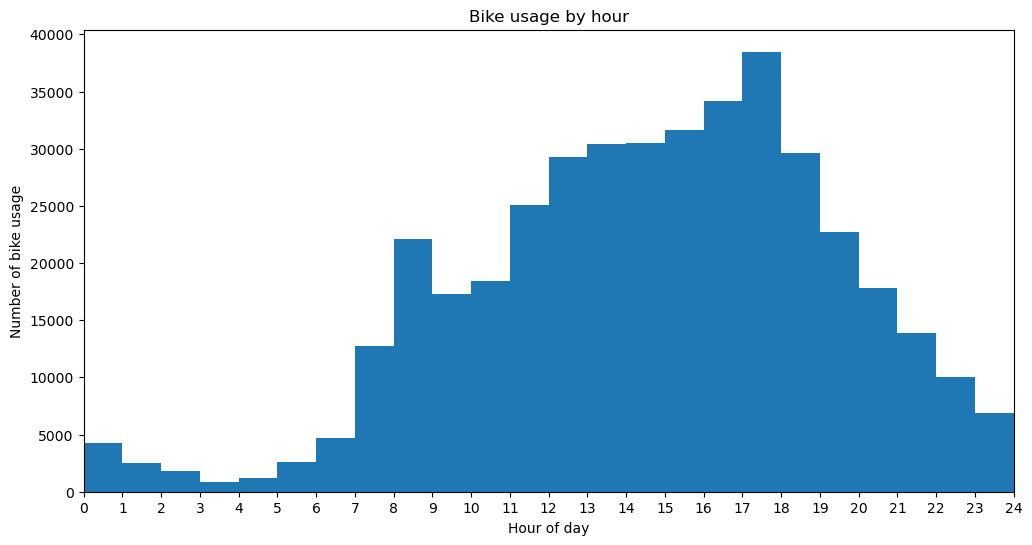

In [33]:
# Plotting the distiribution of Bike usage by hour 

start_hour = pd.to_datetime(data["StartTime"], format="%H:%M:%S").dt.hour

plt.figure(figsize=(12, 6))
plt.hist(start_hour, bins=24, range=(0, 24))

plt.xlabel("Hour of day")
plt.ylabel("Number of bike usage")
plt.title("Bike usage by hour")

plt.xticks(range(0, 25))
plt.xlim(0, 24)
plt.show()

### Conclusion

The pattern suggests a **hybrid usage behavior**:
- Strong commuter influence (clear morning and evening peaks)
- Continuous daytime demand (not only commute-driven)
- Minimal nighttime activity

This indicates that the bike system serves both **commuters** and **leisure/errand users**, making it a versatile transportation option throughout the day.


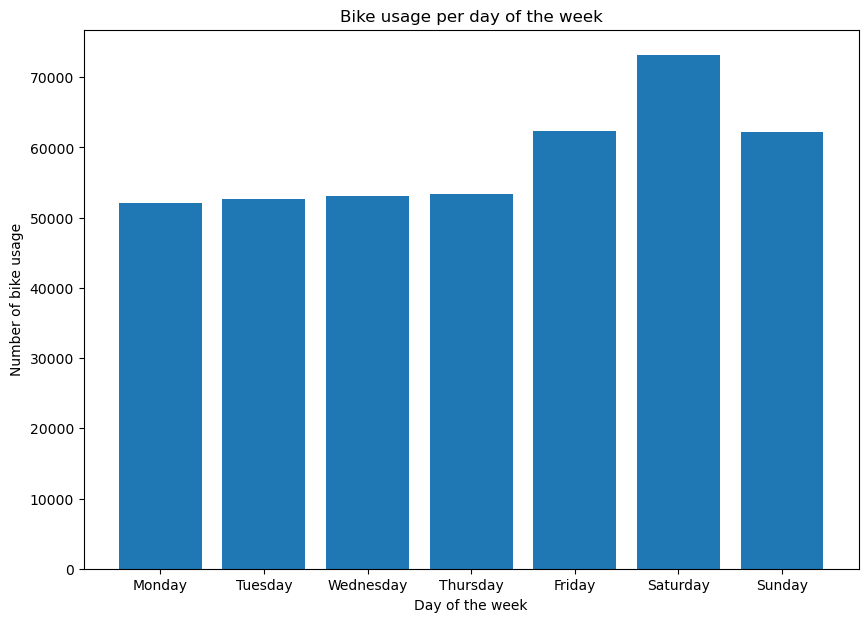

In [34]:
# Order the days
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count occurrences and reorder
counts = data["day_of_week"].value_counts().reindex(order, fill_value=0)


plt.figure(figsize=(10, 7))
plt.bar(counts.index, counts.values)

plt.xlabel("Day of the week")
plt.ylabel("Number of bike usage")
plt.title("Bike usage per day of the week")

plt.show()


### Conclusion

The pattern suggests a dual usage behavior of the bike system:
- **Weekdays:** Dominated by consistent, routine-based usage (likely commuting).
- **Weekends:** Characterized by increased and more variable usage, driven by leisure and recreational activities.

This indicates that the bike system serves both as a practical commuting tool during the week and as a leisure-oriented transportation option on weekends.

In [35]:
# Take out the week number of the date
data["week_number"] = data["StartDate"].dt.isocalendar().week.astype(int)

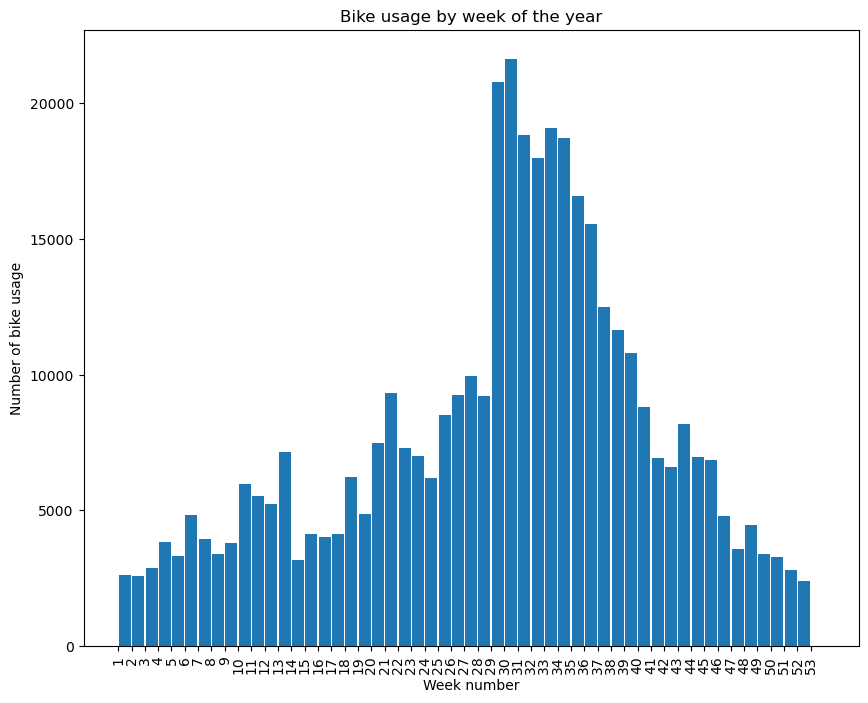

In [36]:
plt.figure(figsize=(10, 8))

weeks = data['week_number'].value_counts().sort_index()

plt.hist(data["week_number"], bins=range(1, 55), rwidth=0.9)

plt.xlabel("Week number")
plt.ylabel("Number of bike usage")
plt.title("Bike usage by week of the year")

plt.xticks(range(1, 54), rotation=90)

plt.show()

## Interpretation of Bike Usage by Week of the Year (All Years Combined)

The distribution shows a clear seasonal pattern when aggregating bike usage across all years.

Usage gradually increases from the beginning of the year, reaching its highest levels between approximately **week 30 and week 40**. This period corresponds to late summer and early autumn, when weather conditions are typically most favorable for outdoor activities.

After week 40, usage steadily declines toward the end of the year.

### Important Note

This plot represents **aggregated usage across all years**, meaning that the observed peak is a combined effect of multiple years. While it reveals a strong seasonal trend, it does not show whether this pattern is consistent year over year or if some years deviate from it.

To fully understand year-specific behavior, the distribution should be analyzed separately for each year.


In [37]:
data['StartDate'].dt.year.value_counts()

StartDate
2017    240574
2016    138696
2018     29610
Name: count, dtype: int64

In [38]:
# Take the year out
data['Year'] = data['StartDate'].dt.year
    

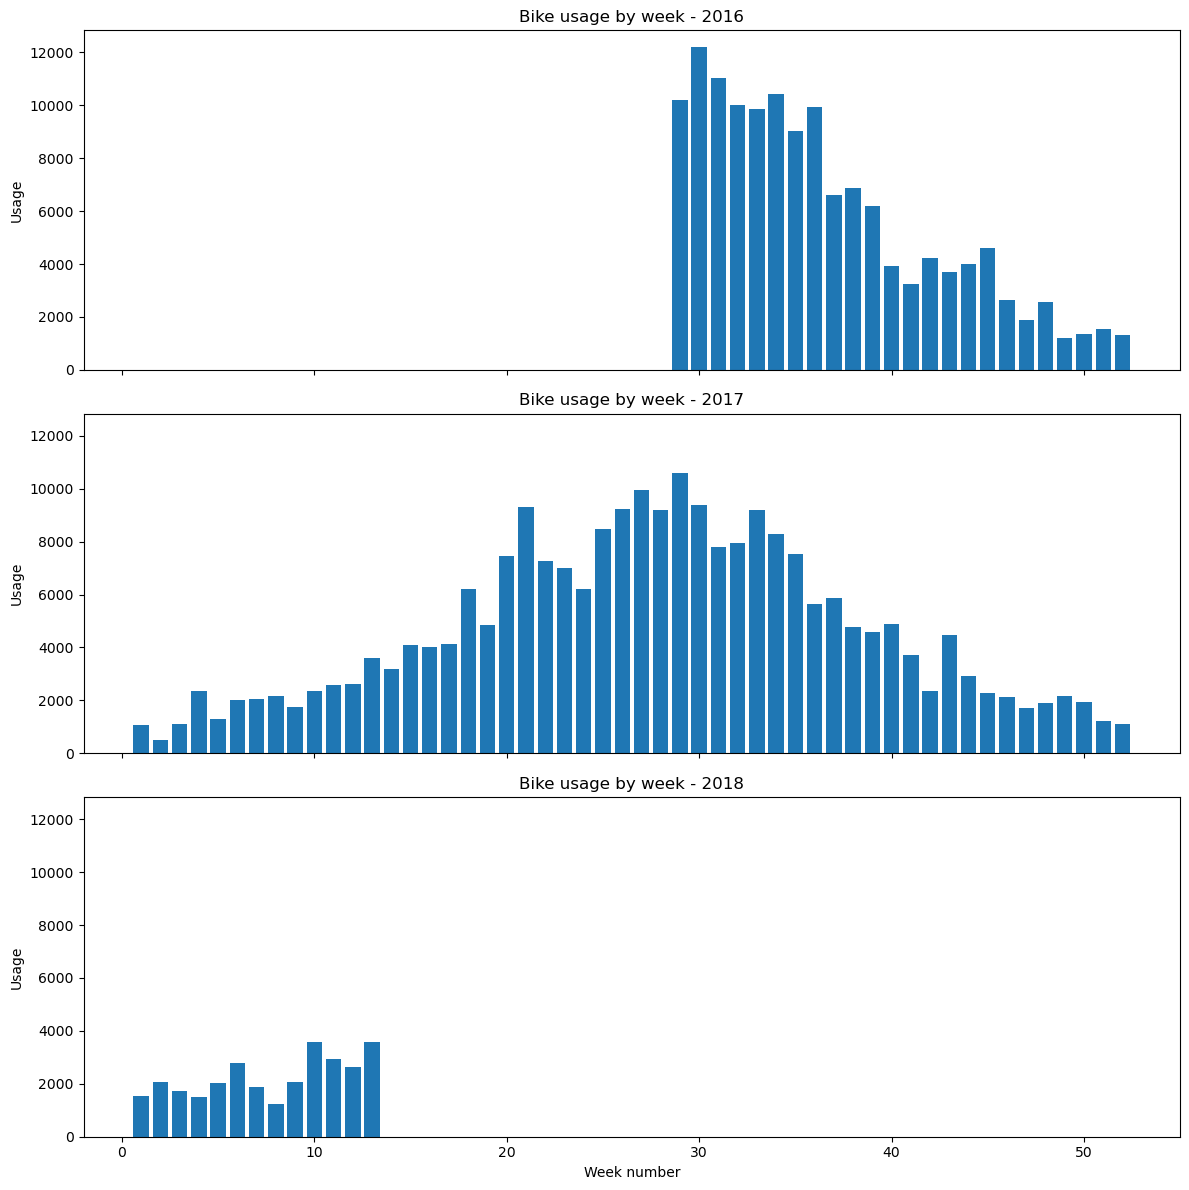

In [39]:
# Grouped weekly counts per year
weekly_counts = (
    data
    .groupby("Year")["week_number"]
    .value_counts()
    .sort_index()
)

# Get the years
years = weekly_counts.index.get_level_values(0).unique()

# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True, sharey=True)

for ax, year in zip(axes, years):
    year_data = weekly_counts.loc[year]
    
    ax.bar(year_data.index, year_data.values)
    ax.set_title(f"Bike usage by week - {year}")
    ax.set_ylabel("Usage")

axes[-1].set_xlabel("Week number")

plt.tight_layout()
plt.show()

## Bike Usage by Week of the Year (Per-Year Analysis)

Across years, bike usage follows a clear **seasonal trend**, with demand rising in spring, peaking in summer, and declining in autumn and winter. This pattern is consistent with weather-driven behavior, where warmer temperatures and longer daylight hours encourage cycling.

Although the exact peak timing and magnitude differ slightly by year, the underlying seasonal structure remains stable. This confirms that bike usage is strongly influenced by environmental and seasonal factors rather than random variation.


In [40]:
# Create the seasons

month = data["StartDate"].dt.month

data["season"] = pd.cut(
    month,
    bins=[0, 2, 5, 8, 11, 12],
    labels=["winter", "spring", "summer", "autumn", "winter"],
    include_lowest=True,
    ordered=False
)

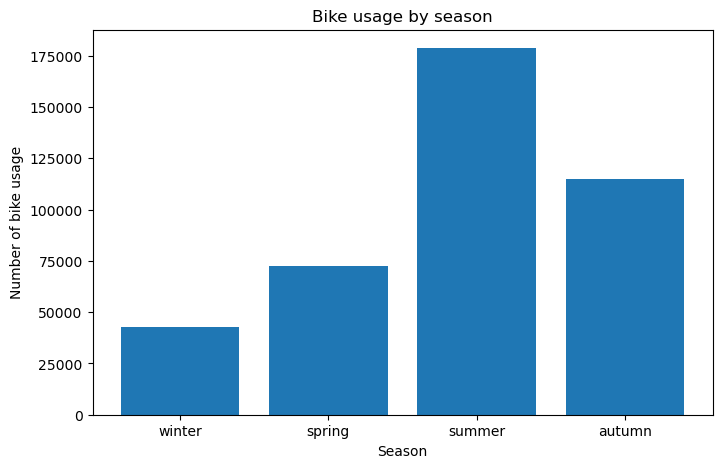

In [41]:
# Plot Bike usage per season

counts = data["season"].value_counts().reindex(["winter","spring","summer","autumn"])
plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.xlabel("Season")
plt.ylabel("Number of bike usage")
plt.title("Bike usage by season")
plt.show()

## Interpretation of Bike Usage by Season

This seasonal view validates the earlier conclusions derived from weekly and hourly analyses:

- Bike usage is **not evenly distributed** throughout the year.
- Demand is **strongly seasonal**.
- Environmental factors play a major role in determining usage patterns.

Together, these findings indicate that the bike system is heavily influenced by climate and daylight conditions, with summer being the dominant usage period.


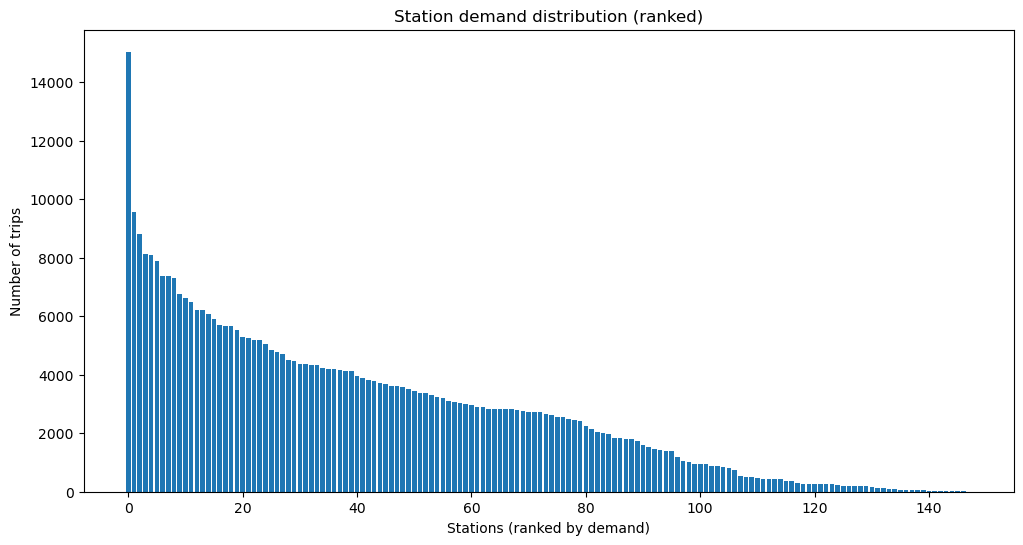

In [42]:
#Plot Station Distribution by demand

stations = data["StartHub"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(range(len(stations)), stations.values)
# plt.yscale("log") # Log scale

plt.xlabel("Stations (ranked by demand)")
plt.ylabel("Number of trips")
plt.title("Station demand distribution (ranked)")
plt.show()


The distribution of trips across stations shows a clear long-tail pattern.

One station stands out as a clear peak, indicating a highly central or strategically important location. Beyond this, demand declines gradually across stations, confirming that usage is not uniformly distributed.

Such a pattern has important operational implications, particularly for bike rebalancing, capacity planning, and station optimization.


In [43]:
# Top / Bottom 10 Stations

top_10 = data["StartHub"].value_counts().head(10)
bottom_10 = data["StartHub"].value_counts().tail(10)

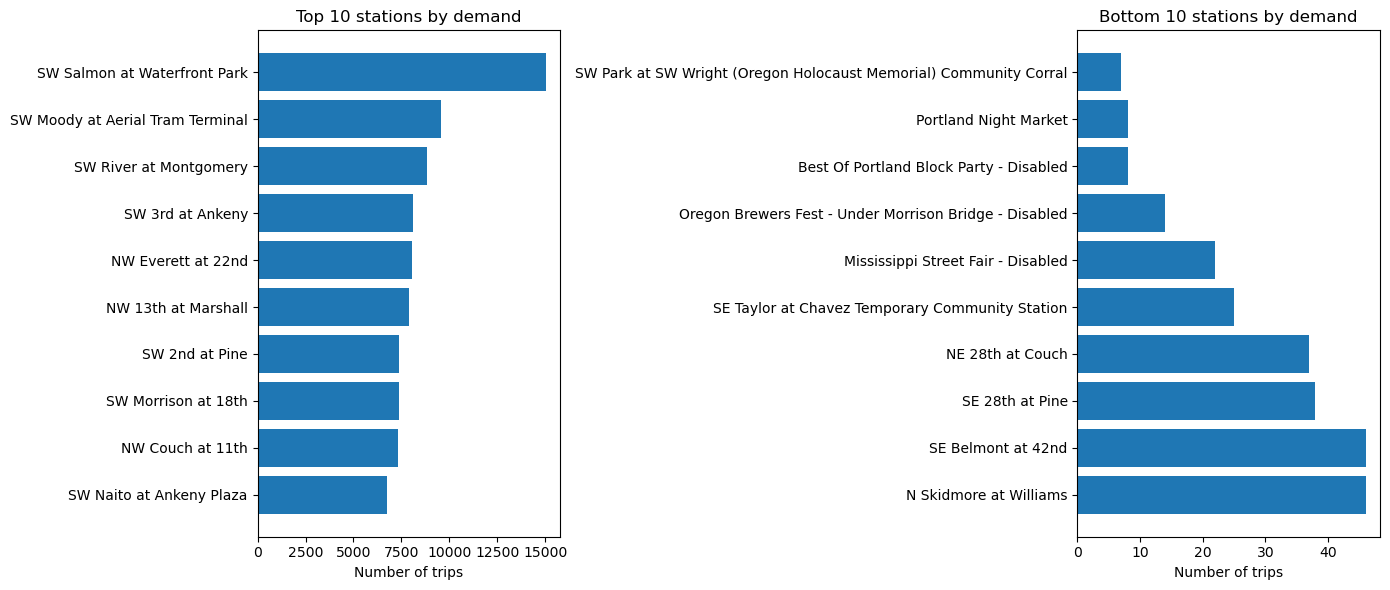

In [44]:
# Plot 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=False)

# Top 10
axes[0].barh(top_10.index, top_10.values)
axes[0].set_title("Top 10 stations by demand")
axes[0].set_xlabel("Number of trips")
axes[0].invert_yaxis()

# Bottom 10
axes[1].barh(bottom_10.index, bottom_10.values)
axes[1].set_title("Bottom 10 stations by demand")
axes[1].set_xlabel("Number of trips")

plt.tight_layout()
plt.show()


In [ ]:
# Distribution of average daily demand per station

# How often does a station have zero departures per day?

# How correlated is demand with:

#     Yesterday?

#     Same weekday last week?

## 3. Feature Engineering

This is a statistical ML project, so we rely on meaningful features.

Core features

Lagged demand:

demand(t−1), demand(t−2), …

Rolling statistics:

rolling mean (last 3, 6, 24 hours)

Calendar features:

hour, weekday, is_weekend

Trend indicators:

cumulative demand index

Avoid:

Black-box embeddings

Neural networks (not needed here)

## 4. Model Selection

We’ll deliberately compare interpretable, strong baselines.

Recommended models (in order)

Baseline

    Historical mean by hour/day

Linear Regression with Lags

    Strong, interpretable

Regularized Regression

    Ridge / Lasso

Tree-based

    Random Forest

    Gradient Boosting (optional)

Each model answers a question:

    Is demand mostly linear and seasonal?

    Do nonlinear interactions matter?

## 5. Evaluation Strategy

Do NOT use random train-test split ❌

Correct approach:

    Time-based split

        Train: early period

        Test: later period

Metrics:

    MAE (easy to interpret)

    RMSE (penalizes large errors)

Tie metric choice to business impact:

    “An error of ±5 bikes per hour means X unavailable bikes at peak time.”

## 6. Optimization Interpretation (Business Angle)

This is what upgrades your project from “student” to “professional”:

Translate forecasts into decisions:

When should bikes be rebalanced?

Which hours are high-risk for shortages?

How much buffer capacity is needed?

You don’t need optimization algorithms yet — interpretation is enough.